# Boston Vaccination Research 

In [141]:
from census import Census
from us import states

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import openpyxl



In [163]:
# Replace YOUR_API_KEY with your actual API key
API_KEY = "aeca2098dcfc8374d3603b771c156c791c87be50"
census_data = Census(API_KEY)  

In [ ]:
# get census data
def get_data_for_year(census, year, county_code, variables):
    """Retrieve data from Census API for a given year, state, county, and fields."""
    data = census.acs5.state_county(list(variables.keys()), states.MA.fips, county_code, year = year)
    return data

In [183]:

# 'New Bedford'-005, 'Wellesley'-021, 'Chelsea'-025, 'Revere'-025, 'Newton'-017
county_code = ['025','021','017','005']
years = [2020, 2021]

variables = {
    'B01003_001E': 'Total Population',
    'B17001_002E': 'Below Poverty Level',
    'B01001_020E': 'Population Over 65',
    'B08201_002E': 'Households with No Vehicle',
    'B15003_002E': 'No High School Diploma (25+)',
    'B19013_001E': 'Median Household Income',
    'B15003_017E': 'High School Diploma',
    'B15003_022E': 'Bachelors Degree',
    'B15003_023E': 'Masters Degree',
    'B15003_024E': 'Professional School Degree',
    'B15003_025E': 'Doctorate Degree',
    'B23025_002E': 'Labor Force',
    'B23025_004E': 'Employed',
    'B23025_005E': 'Unemployed'
}

all_data = []
for year in years:
    for code in county_code:
        data = get_data_for_year(census_data, year, code, variables)
        df = pd.DataFrame(data)
        df['year'] = year
        df['county'] = str(code)
        all_data.append(df)

census_df = pd.concat(all_data)

census_df.head()

,B01003_001E,B17001_002E,B01001_020E,B08201_002E,B15003_002E,B19013_001E,B15003_017E,B15003_022E,B15003_023E,B15003_024E,B15003_025E,B23025_002E,B23025_004E,B23025_005E,state,county,year
0,801162.0,131619.0,5696.0,99726.0,15011.0,74881.0,101671.0,146876.0,77148.0,25108.0,17061.0,476035.0,442673.0,32462.0,25,025,2020
0,703740.0,41067.0,7082.0,24887.0,5515.0,105320.0,83425.0,142423.0,86438.0,22477.0,18806.0,394476.0,376643.0,17599.0,25,021,2020
0,1605899.0,112373.0,16715.0,64294.0,15163.0,106202.0,185829.0,317752.0,221889.0,45901.0,59167.0,929011.0,888786.0,38804.0,25,017,2020
0,563301.0,58446.0,6135.0,22164.0,8132.0,71450.0,103048.0,74178.0,31709.0,5495.0,4137.0,300252.0,283747.0,16304.0,25,005,2020
0,792647.0,129207.0,6108.0,100217.0,16581.0,80260.0,99831.0,144811.0,78839.0,25222.0,17304.0,470235.0,436945.0,32537.0,25,025,2021


In [184]:
# map column names to more descriptive names
census_df = census_df.rename(columns=variables).reset_index(drop=True)
# map county codes to county names
county_codes = {
    '025': 'Suffolk',
    '021': 'Norfolk',
    '017': 'Middlesex',
    '005': 'Bristol'
}

census_df['county'] = census_df['county'].map(county_codes)
census_df

,Total Population,Below Poverty Level,Population Over 65,Households with No Vehicle,No High School Diploma (25+),Median Household Income,High School Diploma,Bachelors Degree,Masters Degree,Professional School Degree,Doctorate Degree,Labor Force,Employed,Unemployed,state,county,year
0,801162.0,131619.0,5696.0,99726.0,15011.0,74881.0,101671.0,146876.0,77148.0,25108.0,17061.0,476035.0,442673.0,32462.0,25,Suffolk,2020
1,703740.0,41067.0,7082.0,24887.0,5515.0,105320.0,83425.0,142423.0,86438.0,22477.0,18806.0,394476.0,376643.0,17599.0,25,Norfolk,2020
2,1605899.0,112373.0,16715.0,64294.0,15163.0,106202.0,185829.0,317752.0,221889.0,45901.0,59167.0,929011.0,888786.0,38804.0,25,Middlesex,2020
3,563301.0,58446.0,6135.0,22164.0,8132.0,71450.0,103048.0,74178.0,31709.0,5495.0,4137.0,300252.0,283747.0,16304.0,25,Bristol,2020
4,792647.0,129207.0,6108.0,100217.0,16581.0,80260.0,99831.0,144811.0,78839.0,25222.0,17304.0,470235.0,436945.0,32537.0,25,Suffolk,2021
5,720403.0,43922.0,7580.0,25243.0,6527.0,112089.0,82607.0,147352.0,90784.0,23360.0,20003.0,407776.0,386932.0,20588.0,25,Norfolk,2021
6,1623411.0,116510.0,17000.0,65183.0,16759.0,111790.0,184245.0,324877.0,225726.0,46713.0,62668.0,939726.0,895806.0,42519.0,25,Middlesex,2021
7,576070.0,61584.0,6241.0,22546.0,8725.0,74290.0,104605.0,76681.0,32343.0,5526.0,4183.0,306835.0,289204.0,17400.0,25,Bristol,2021


In [187]:

# convert to percentages
census_df['Below Poverty Level (%)'] = (census_df['Below Poverty Level'] / census_df['Total Population']) * 100
census_df['Population Over 65 (%)'] = (census_df['Population Over 65'] / census_df['Total Population']) * 100
census_df['No High School Diploma (25+) (%)'] = (census_df['No High School Diploma (25+)'] / census_df['Total Population']) * 100
census_df['Unemployed Rate (%)'] = (census_df['Unemployed'] / census_df['Labor Force']) * 100



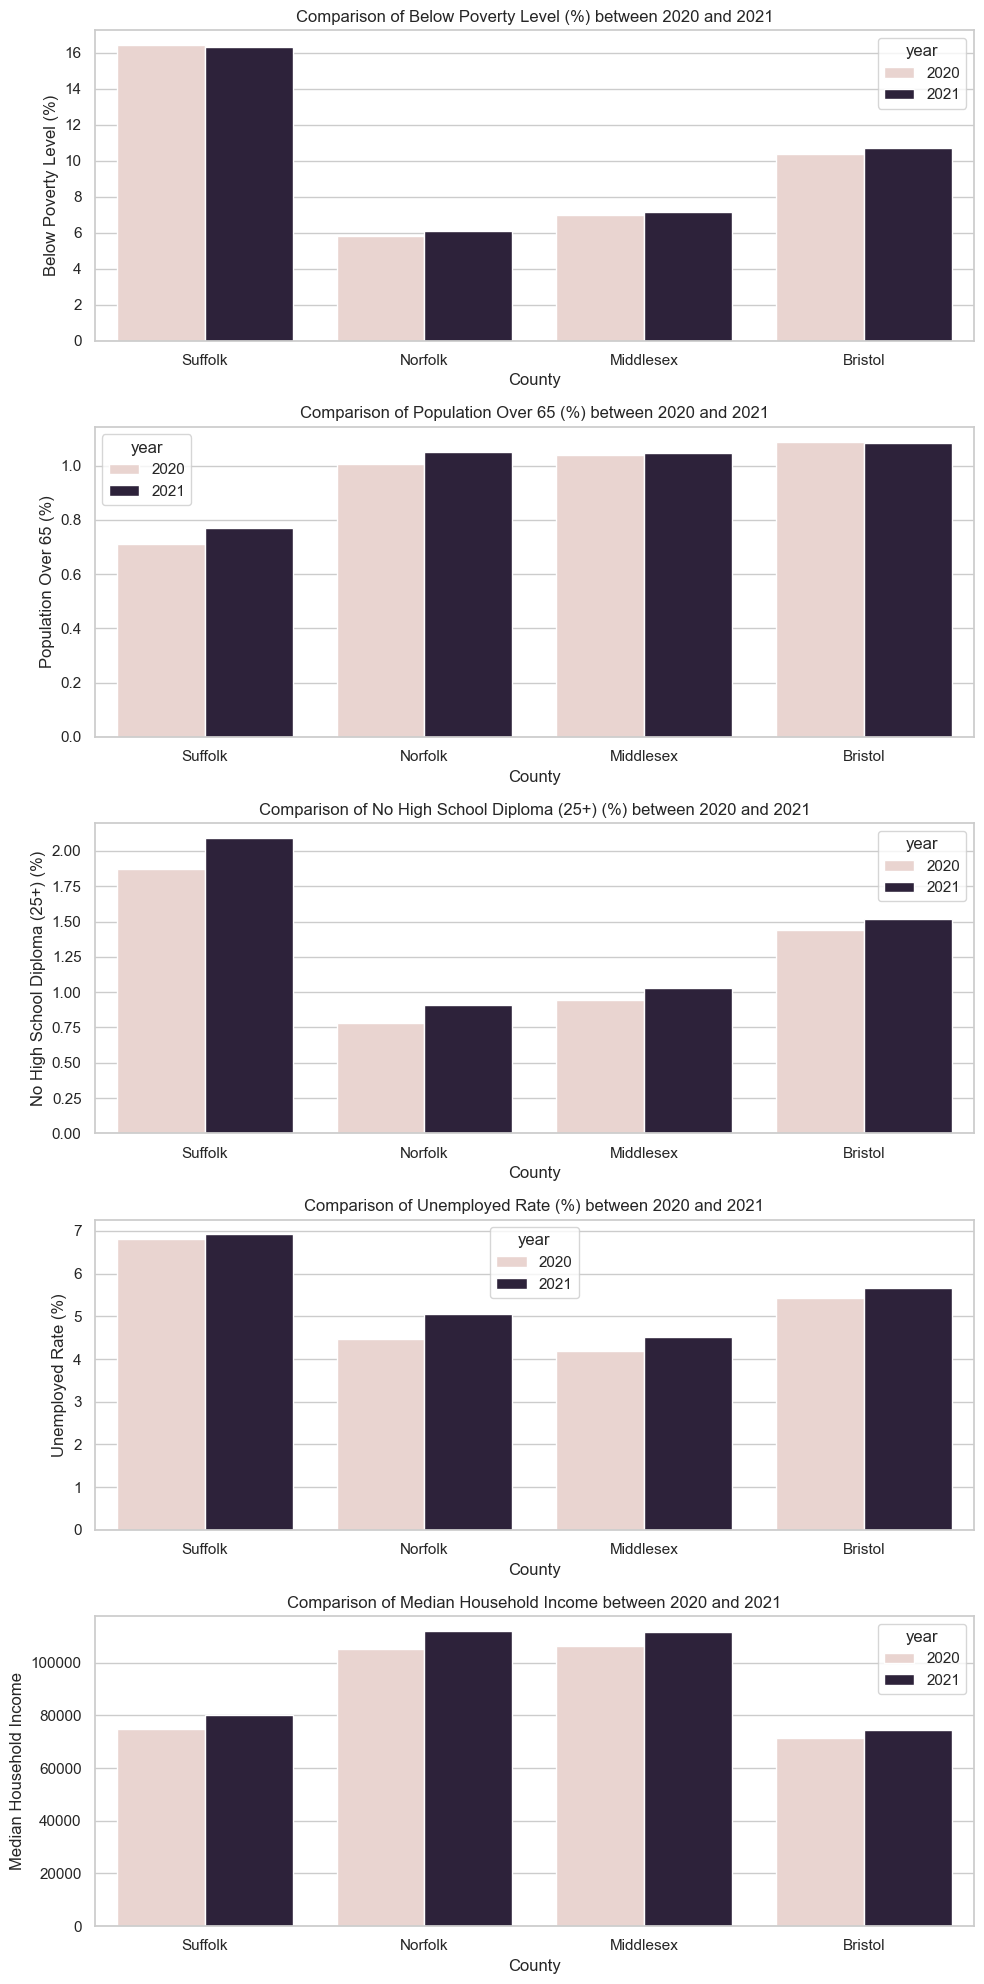

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

variables_to_plot = [
    'Below Poverty Level (%)',
    'Population Over 65 (%)',
    'No High School Diploma (25+) (%)',
    'Unemployed Rate (%)',
    'Median Household Income'
]

# Set the style for seaborn plots
sns.set_style('whitegrid')

# Create a figure with subplots - one for each variable
fig, axes = plt.subplots(nrows=len(variables_to_plot), ncols=1, figsize=(10, 20))

# Loop through each variable to create a bar plot
for i, var in enumerate(variables_to_plot):
    sns.barplot(x='county', y=var, hue='year', data=census_df, ax=axes[i])
    axes[i].set_title(f'Comparison of {var} between 2020 and 2021')
    axes[i].set_ylabel(f'{var}')
    axes[i].set_xlabel('County')

plt.tight_layout()

# Show the plot
plt.show()


## Import the data

In [198]:

# import the data from provided resources
# import vaccination data for race
vac_data = pd.read_excel("/Users/zoeyy/Desktop/vac_equity/ds-bch-vaccine-equity/fa23-team/data/COVID-data_Massachusetts-vaccines.xlsx", sheet_name = 1)
vac_data.head()

,date,county,city,race,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated
0,2021-03-09,Barnstable,Barnstable,AI/AN,251.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-09,Barnstable,Barnstable,Asian,849.0,66.0,38.0,NaN,NaN,NaN,NaN
2,2021-03-09,Barnstable,Barnstable,Black,2610.0,249.0,151.0,NaN,NaN,NaN,98.0
3,2021-03-09,Barnstable,Barnstable,Hispanic,2644.0,232.0,120.0,NaN,NaN,NaN,112.0
4,2021-03-09,Barnstable,Barnstable,Multi,1168.0,122.0,70.0,NaN,NaN,NaN,52.0


## EDA to find data error

In [199]:
# Filtering data for Chelsea, Wellesley, Revere, Newton, New Bedford
vac_data = vac_data[vac_data['city'].isin(['New Bedford', 'Wellesley','Chelsea', 'Revere', 'Newton'])]


In [200]:
# create vac_rate

vac_data['fully_vac_rate'] = round((vac_data['fully_vaccinated'] / vac_data['population']),2) * 100
vac_data['partially_vac_rate'] = round((vac_data['partially_vaccinated'] / vac_data['population']),2) * 100
vac_data['onedose_vac_rate'] = round((vac_data['atleast_onedose'] / vac_data['population']),2) * 100
vac_data['boosted_rate'] = round((vac_data['boosted'] / vac_data['population']),2) * 100



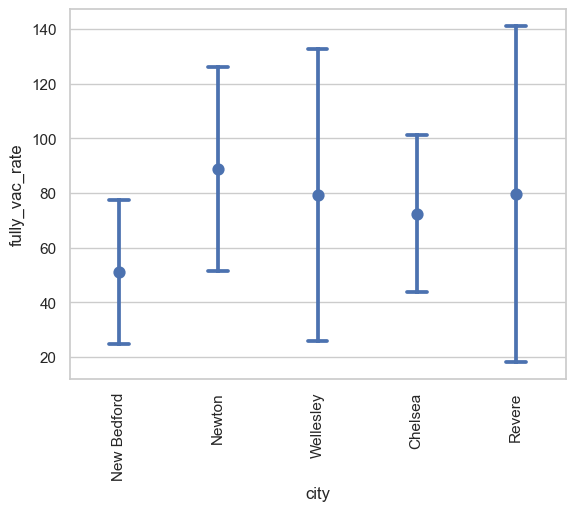

In [201]:
sns.pointplot(x = 'city', y='fully_vac_rate', data=vac_data, errorbar='sd',capsize = 0.2, linestyles = 'none')
plt.xticks(rotation = 90)
plt.show()

In [142]:
# Custom function to apply to each row
def check_vac(row):
    vaccination_columns = ["fully_vaccinated", "atleast_onedose", "boosted", "boosted_second", "partially_vaccinated"]
    for col in vaccination_columns:
        if row[col] > row["population"]:
            row[col] = np.nan
    return row

# Apply the function across the DataFrame row-wise
vac_data = vac_data.apply(check_vac, axis=1)

## Data Preprocessing

In [145]:
# 0. take out the city we are interested in 

# check missing values
vac_data.isna().sum()


date                           0
county                         0
city                           0
race                           0
population                   530
atleast_onedose             1920
fully_vaccinated            1620
boosted_after_2022-09-01    4884
boosted                     2982
boosted_second              3713
partially_vaccinated        2738
fully_vac_rate              2000
partially_vac_rate          3083
onedose_vac_rate            2300
boosted_rate                2997
dtype: int64

In [146]:
# 1. missing data & replace population with max population within the same city and race.
## 1.1 create date column
vac_data['year'] = vac_data['date'].dt.year
vac_data['month'] = vac_data['date'].dt.month
vac_data['year_month'] = vac_data['date'].dt.to_period('M')

#using the max population replace the missing population
vac_data['population'] = vac_data.groupby(['year','city','race'])['population'].transform(lambda x: x.fillna(x.max()))

#using the max population replace the population
vac_data['population'] = vac_data.groupby(['year','city','race'])['population'].transform(lambda x: x.max())

print(vac_data.head(10))

           date     county         city           race  population  \
450  2021-03-09    Bristol  New Bedford          AI/AN       498.0   
451  2021-03-09    Bristol  New Bedford          Asian      1370.0   
452  2021-03-09    Bristol  New Bedford          Black      8772.0   
453  2021-03-09    Bristol  New Bedford       Hispanic     23410.0   
454  2021-03-09    Bristol  New Bedford          Multi      3891.0   
455  2021-03-09    Bristol  New Bedford          NH/PI        24.0   
456  2021-03-09    Bristol  New Bedford          White     62497.0   
457  2021-03-09    Bristol  New Bedford  Other/Unknown         NaN   
458  2021-03-09    Bristol  New Bedford          Total     99980.0   
1755 2021-03-09  Middlesex       Newton          AI/AN        64.0   

      atleast_onedose  fully_vaccinated  boosted_after_2022-09-01  boosted  \
450               NaN               NaN                       NaN      NaN   
451              80.0              36.0                       NaN      Na

In [191]:
# 2. transform data into monthly data

# Group by 'year', 'month', 'city', and 'race' and then take the max
monthly_data = vac_data.drop(columns=['date'])
monthly_data = monthly_data.groupby(['year', 'month', 'city', 'race']).max().reset_index()


monthly_data.head(10)


,year,month,city,race,county,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated,fully_vac_rate,partially_vac_rate,onedose_vac_rate,boosted_rate,year_month
0,2021,3,Chelsea,AI/AN,Suffolk,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03
1,2021,3,Chelsea,Asian,Suffolk,810.0,374.0,201.0,NaN,NaN,NaN,173.0,25.0,21.0,46.0,NaN,2021-03
2,2021,3,Chelsea,Black,Suffolk,3336.0,608.0,372.0,NaN,NaN,NaN,236.0,11.0,7.0,18.0,NaN,2021-03
3,2021,3,Chelsea,Hispanic,Suffolk,25092.0,3357.0,1849.0,NaN,NaN,NaN,1508.0,7.0,6.0,13.0,NaN,2021-03
4,2021,3,Chelsea,Multi,Suffolk,420.0,118.0,77.0,NaN,NaN,NaN,41.0,18.0,10.0,28.0,NaN,2021-03
5,2021,3,Chelsea,NH/PI,Suffolk,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03
6,2021,3,Chelsea,Other/Unknown,Suffolk,NaN,1568.0,906.0,NaN,NaN,NaN,662.0,NaN,NaN,NaN,NaN,2021-03
7,2021,3,Chelsea,Total,Suffolk,36918.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03
8,2021,3,Chelsea,White,Suffolk,7307.0,3409.0,2309.0,NaN,NaN,NaN,1100.0,32.0,15.0,47.0,NaN,2021-03
9,2021,3,New Bedford,AI/AN,Bristol,498.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,2021-03


In [192]:
# 3. calculate the vaccination rate
# Calculating vaccination rate
monthly_data['fully_vac_rate'] = round((monthly_data['fully_vaccinated'] / monthly_data['population']),2) * 100
monthly_data['partially_vac_rate'] = round((monthly_data['partially_vaccinated'] / monthly_data['population']),2) * 100
monthly_data['onedose_vac_rate'] = round((monthly_data['atleast_onedose'] / monthly_data['population']),2) * 100
monthly_data['boosted_rate'] = round((monthly_data['boosted'] / monthly_data['population']),2) * 100

# exclued data of 'Other/Unknown' in race
monthly_data = monthly_data[~monthly_data['race'].isin(['Other/Unknown'])]

# exclued data of 'NH/PI' in race
monthly_data = monthly_data[~monthly_data['race'].isin(['NH/PI','Multi'])]

# exclued data of 'NH/PI' in race
monthly_data = monthly_data[~monthly_data['race'].isin(['Total'])]


In [193]:
 monthly_data.head(10)

,year,month,city,race,county,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated,fully_vac_rate,partially_vac_rate,onedose_vac_rate,boosted_rate,year_month
0,2021,3,Chelsea,AI/AN,Suffolk,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03
1,2021,3,Chelsea,Asian,Suffolk,810.0,374.0,201.0,NaN,NaN,NaN,173.0,25.0,21.0,46.0,NaN,2021-03
2,2021,3,Chelsea,Black,Suffolk,3336.0,608.0,372.0,NaN,NaN,NaN,236.0,11.0,7.0,18.0,NaN,2021-03
3,2021,3,Chelsea,Hispanic,Suffolk,25092.0,3357.0,1849.0,NaN,NaN,NaN,1508.0,7.0,6.0,13.0,NaN,2021-03
8,2021,3,Chelsea,White,Suffolk,7307.0,3409.0,2309.0,NaN,NaN,NaN,1100.0,32.0,15.0,47.0,NaN,2021-03
9,2021,3,New Bedford,AI/AN,Bristol,498.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,2021-03
10,2021,3,New Bedford,Asian,Bristol,1370.0,124.0,70.0,NaN,NaN,NaN,54.0,5.0,4.0,9.0,NaN,2021-03
11,2021,3,New Bedford,Black,Bristol,8772.0,1422.0,821.0,NaN,NaN,NaN,601.0,9.0,7.0,16.0,NaN,2021-03
12,2021,3,New Bedford,Hispanic,Bristol,23410.0,1450.0,687.0,NaN,NaN,NaN,763.0,3.0,3.0,6.0,NaN,2021-03
17,2021,3,New Bedford,White,Bristol,62497.0,13535.0,8121.0,NaN,NaN,NaN,5474.0,13.0,9.0,22.0,NaN,2021-03


## EDA 

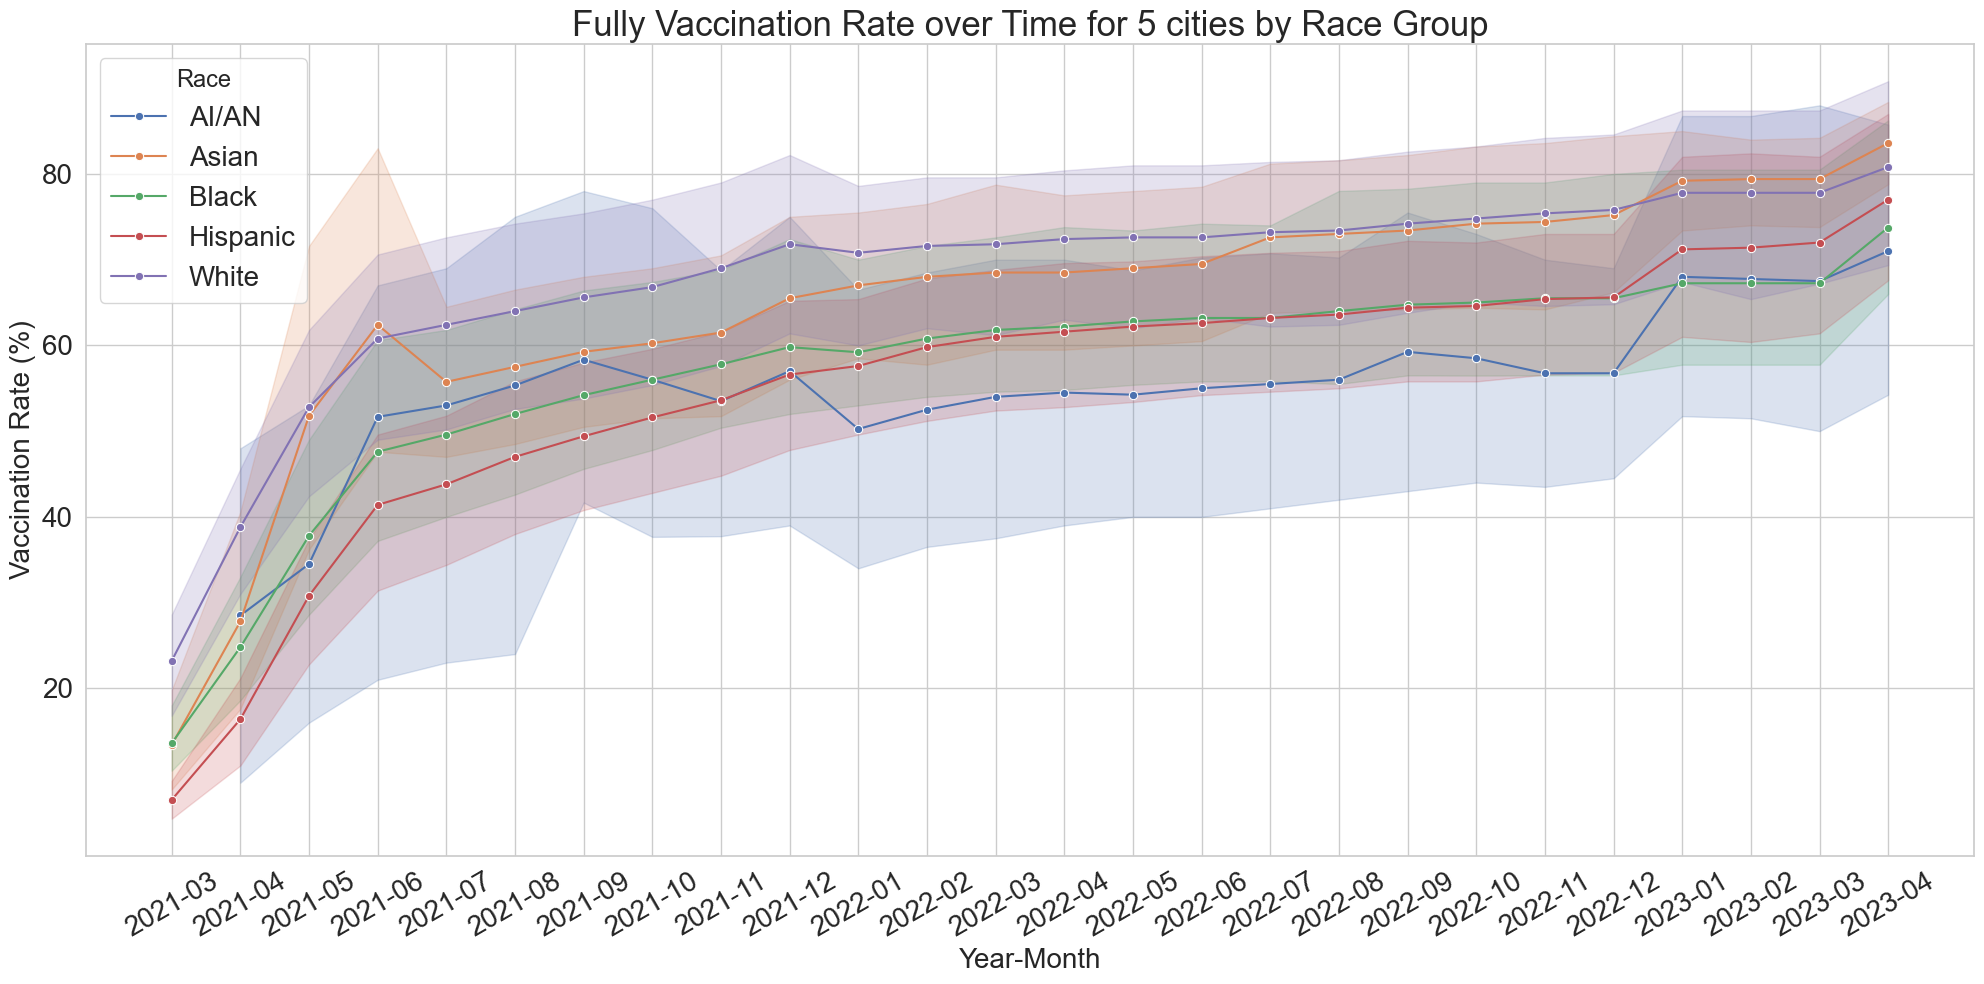

In [194]:
# Plotting fully_vac rate
plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
monthly_data['year_month'] = monthly_data['year_month'].astype(str)
sns.lineplot(data= monthly_data, x='year_month', y='fully_vac_rate', hue='race', marker='o')

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Fully Vaccination Rate over Time for 5 cities by Race Group', fontsize = 25)
plt.ylabel('Vaccination Rate (%)', fontsize = 20)
plt.xlabel('Year-Month', fontsize = 20)

# adjust the tick labels and legend
plt.xticks(rotation = 30, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title='Race', title_fontsize = '17', fontsize = 20, loc = 'upper left')


plt.tight_layout()
plt.show()

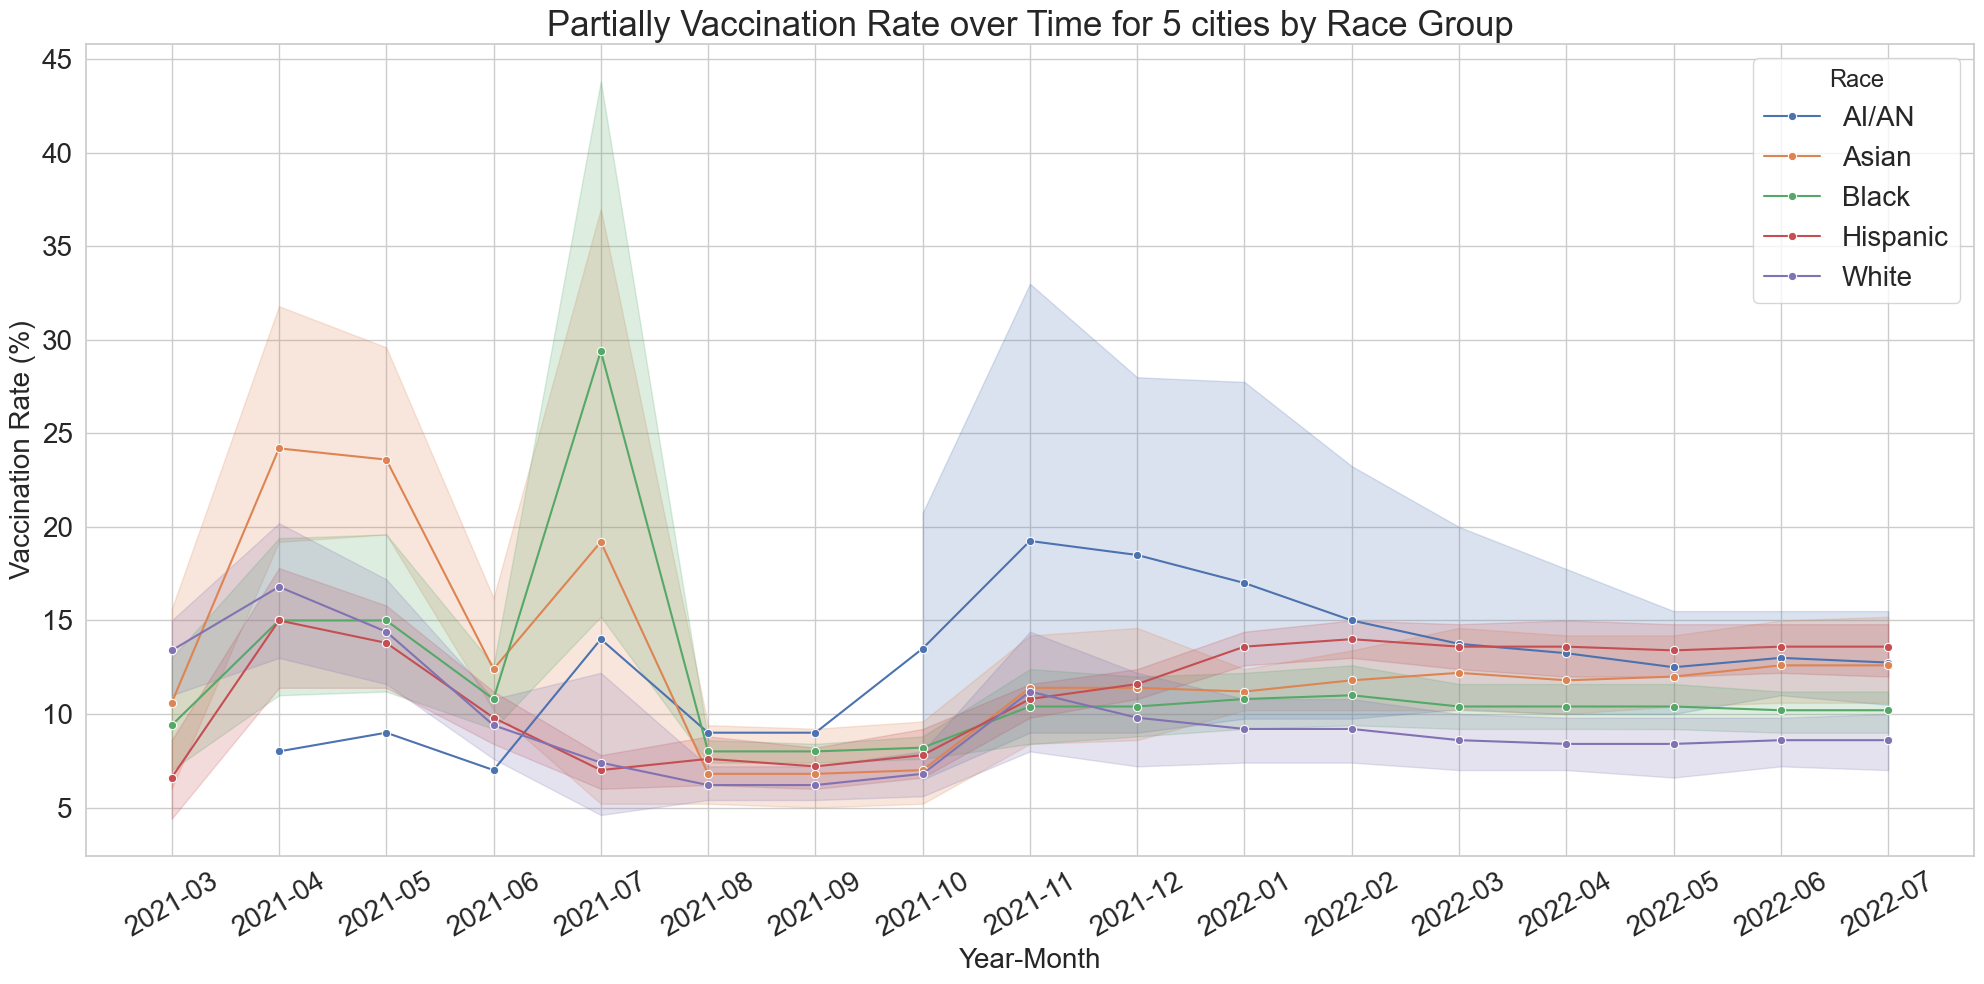

In [195]:
# Plotting partially rate
plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
monthly_data['year_month'] = monthly_data['year_month'].astype(str)
sns.lineplot(data= monthly_data, x='year_month', y='partially_vac_rate', hue='race', marker='o')

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Partially Vaccination Rate over Time for 5 cities by Race Group', fontsize = 25)
plt.ylabel('Vaccination Rate (%)', fontsize = 20)
plt.xlabel('Year-Month', fontsize = 20)

# adjust the tick labels and legend
plt.xticks(rotation = 30, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title='Race', title_fontsize = '17', fontsize = 20, loc = 'upper right')


plt.tight_layout()
plt.show()

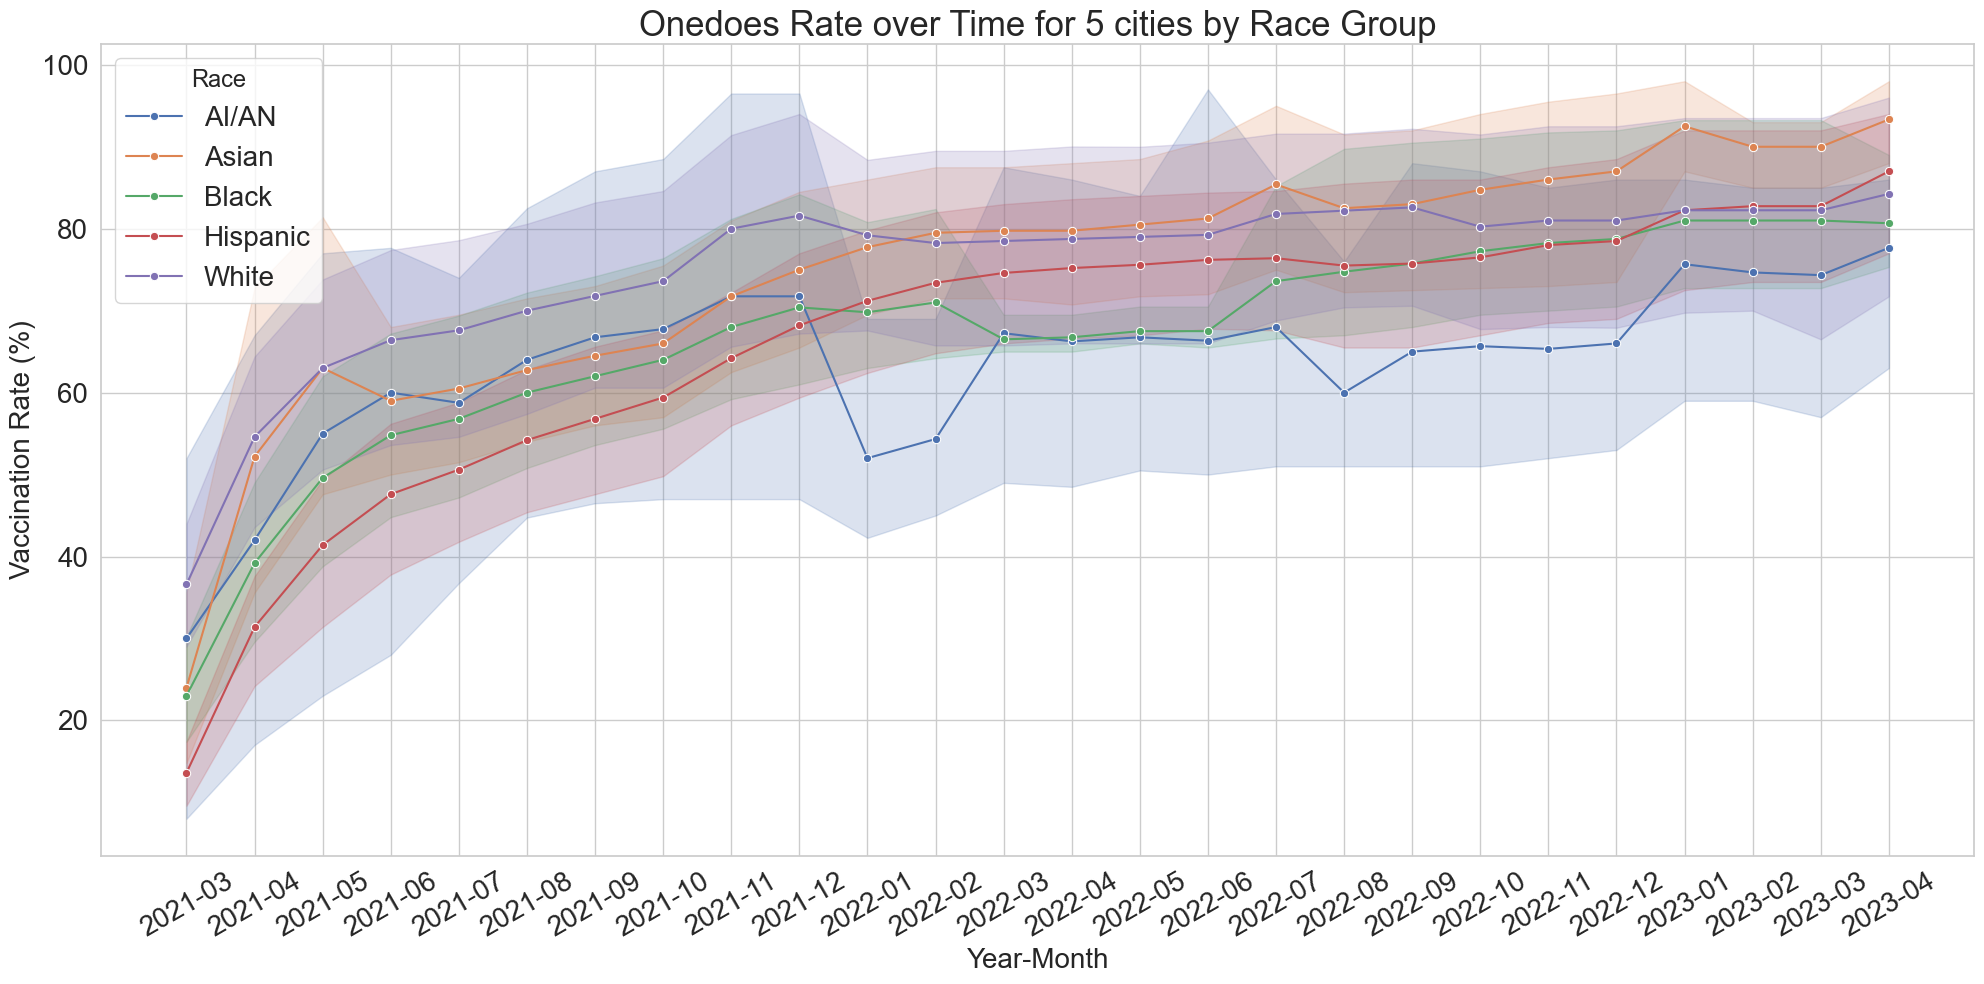

In [196]:
# Plotting fully_vac rate
plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
monthly_data['year_month'] = monthly_data['year_month'].astype(str)
sns.lineplot(data= monthly_data, x='year_month', y='onedose_vac_rate', hue='race', marker='o')

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Onedoes Rate over Time for 5 cities by Race Group', fontsize = 25)
plt.ylabel('Vaccination Rate (%)', fontsize = 20)
plt.xlabel('Year-Month', fontsize = 20)

# adjust the tick labels and legend
plt.xticks(rotation = 30, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title='Race', title_fontsize = '17', fontsize = 20, loc = 'upper left')


plt.tight_layout()
plt.show()

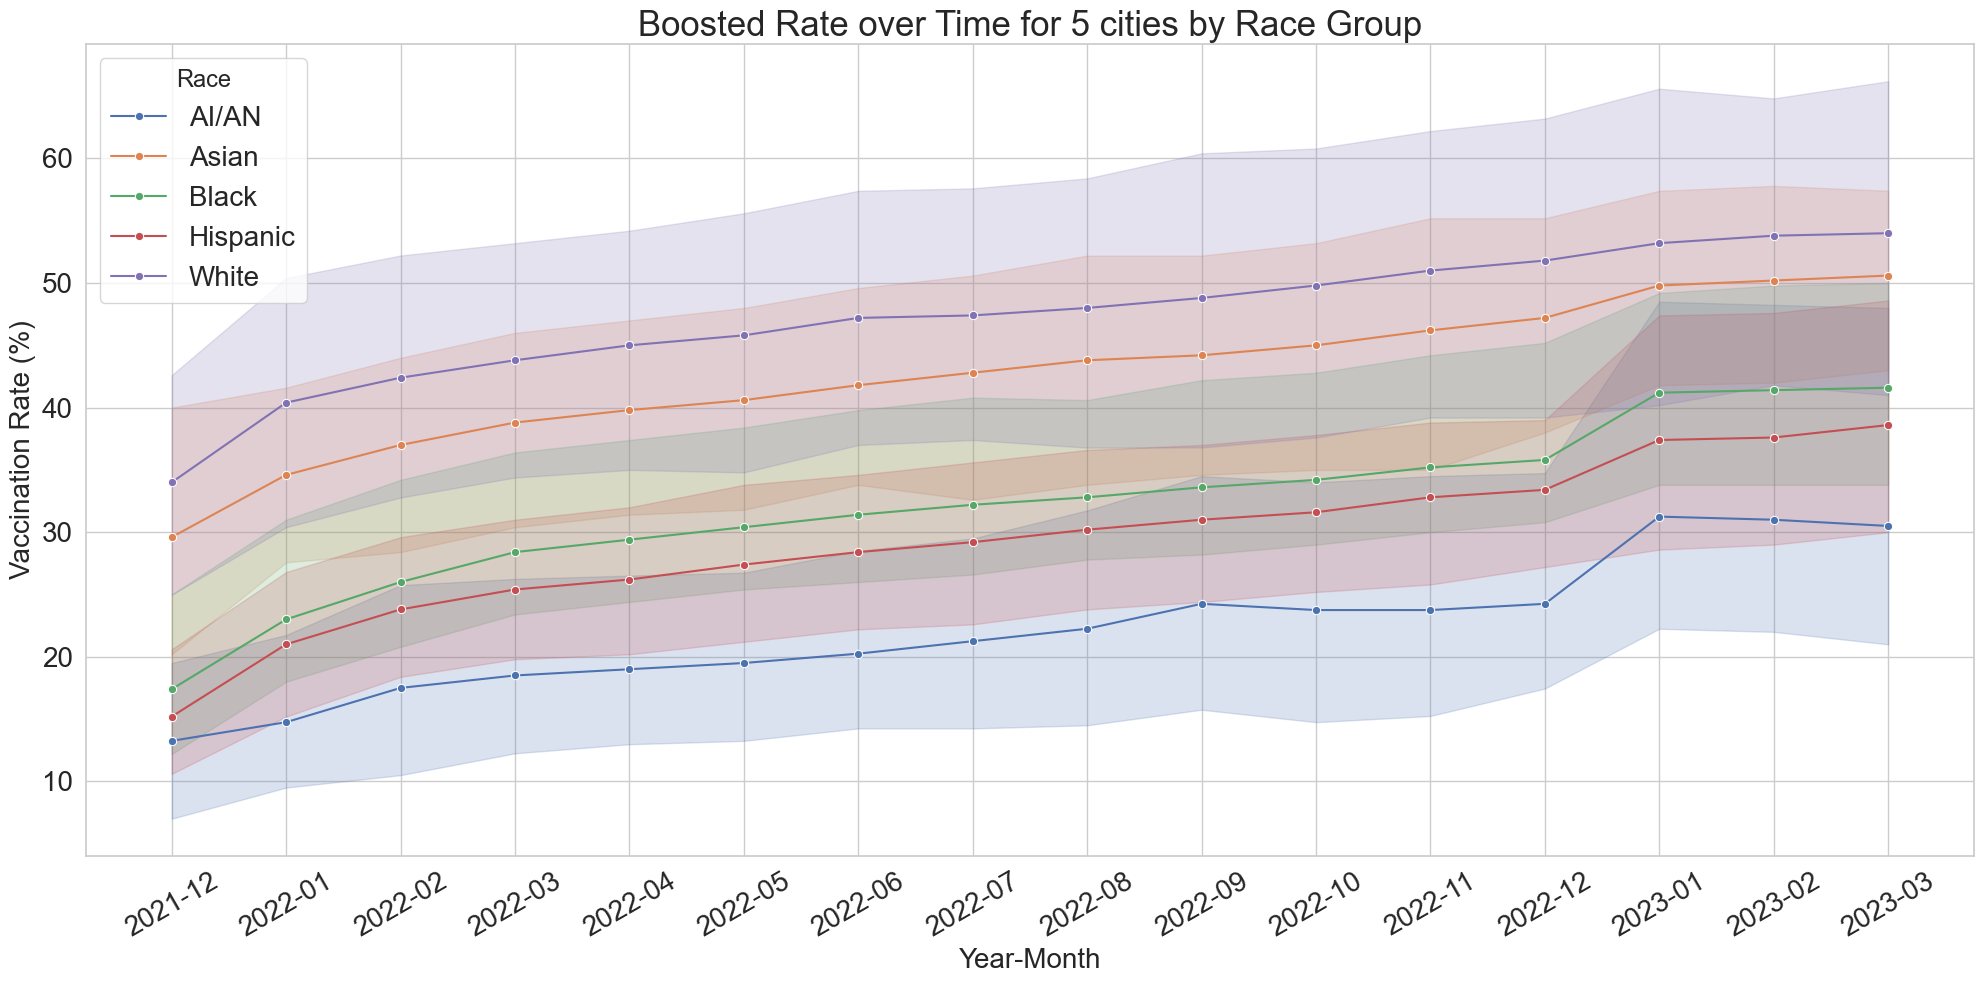

In [197]:
# Plotting fully_vac rate
plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
monthly_data['year_month'] = monthly_data['year_month'].astype(str)
sns.lineplot(data= monthly_data, x='year_month', y='boosted_rate', hue='race', marker='o')

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Boosted Rate over Time for 5 cities by Race Group', fontsize = 25)
plt.ylabel('Vaccination Rate (%)', fontsize = 20)
plt.xlabel('Year-Month', fontsize = 20)

# adjust the tick labels and legend
plt.xticks(rotation = 30, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title='Race', title_fontsize = '17', fontsize = 20, loc = 'upper left')


plt.tight_layout()
plt.show()

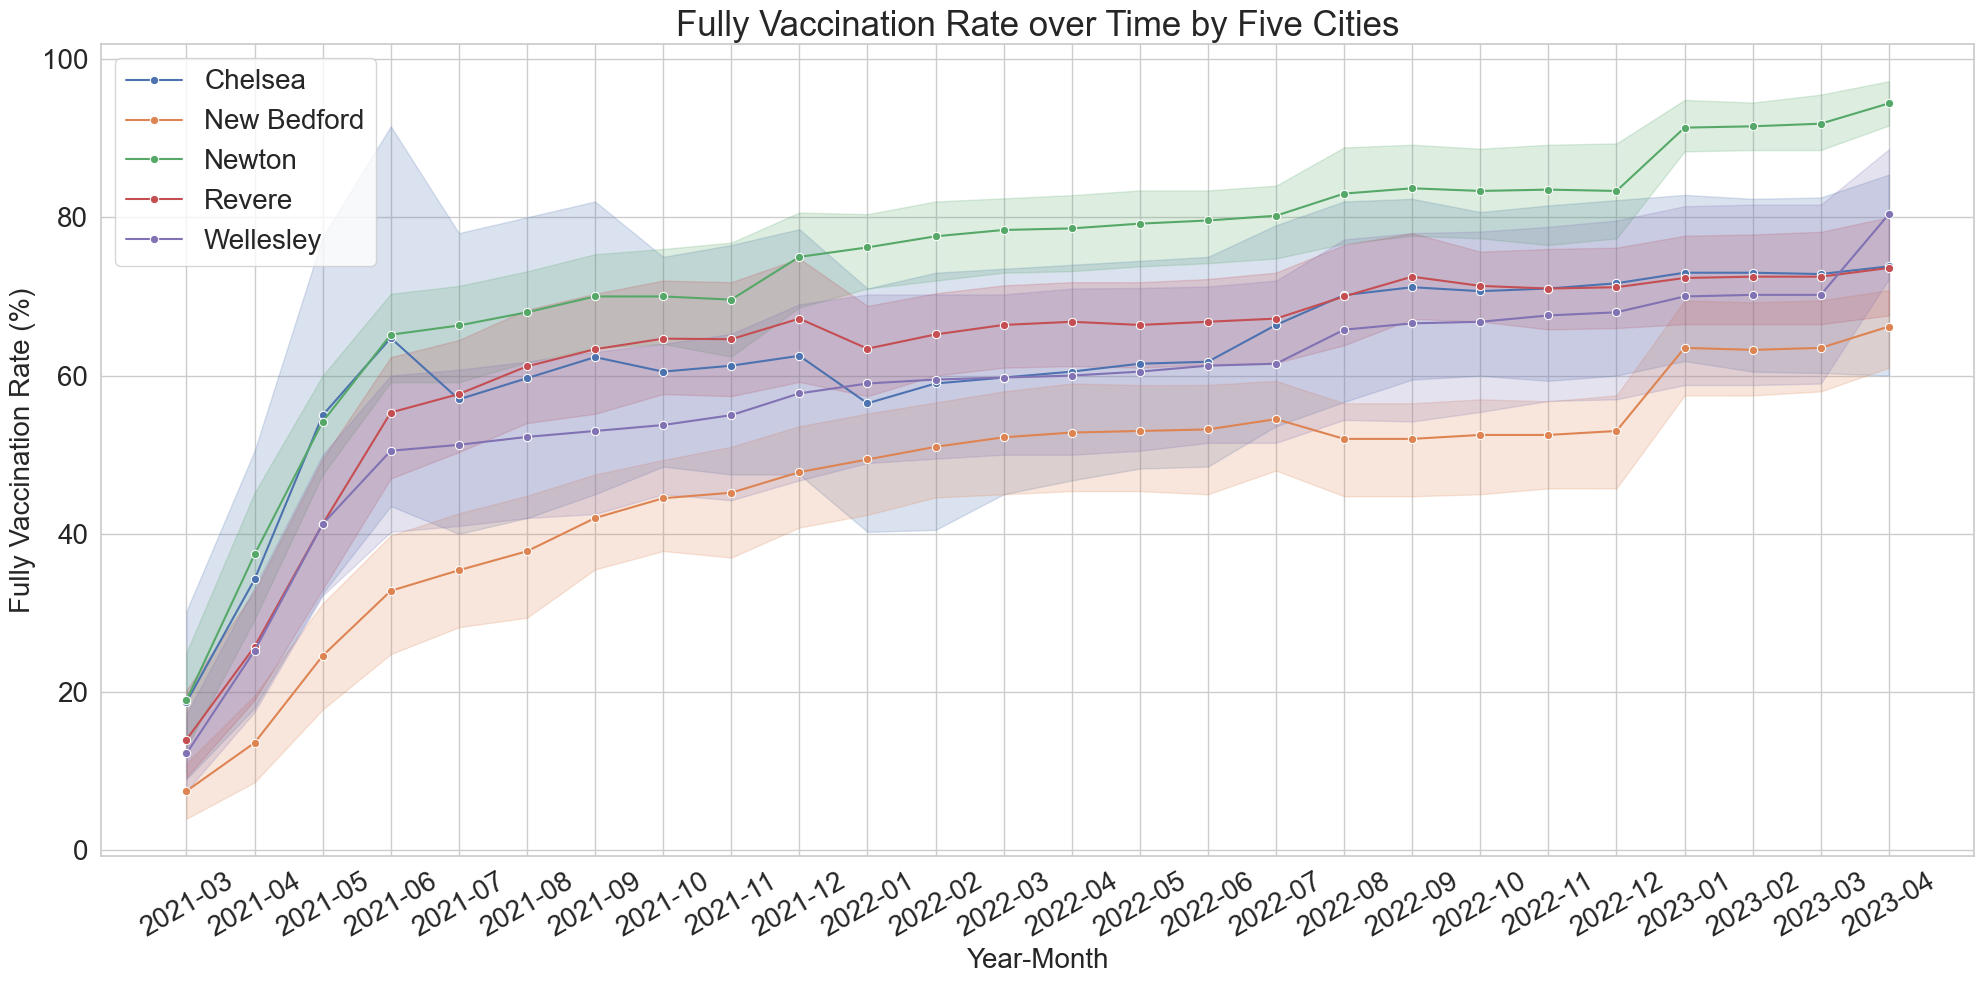

In [157]:
# Plotting fully_vac rate
plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
monthly_data['year_month'] = monthly_data['year_month'].astype(str)
sns.lineplot(data= monthly_data, x='year_month', y='fully_vac_rate', hue='city', marker='o')

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Fully Vaccination Rate over Time by Five Cities', fontsize = 25)
plt.ylabel('Fully Vaccination Rate (%)', fontsize = 20)
plt.xlabel('Year-Month', fontsize = 20)

# adjust the tick labels and legend
plt.xticks(rotation = 30, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title_fontsize = '17', fontsize = 20, loc = 'upper left')


plt.tight_layout()
plt.show()